In [14]:
import numpy as np

dataset_path = '../../data/new_beggining/no_background_interpolated_trainning_clean_mars.npz'

data = np.load(dataset_path)
X_train = data['X_train']
y_train = data['y_train']

X_test = data["X_test"]

[      0 7218673 5493741 4035229   86917]


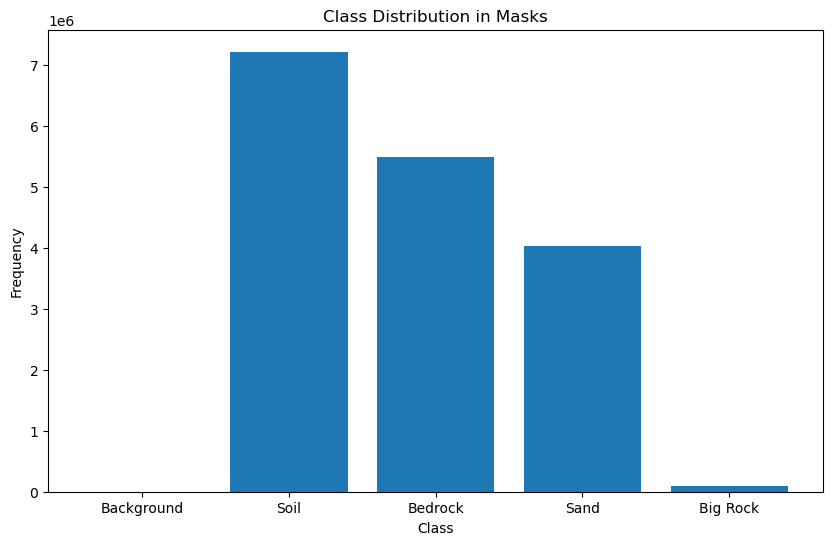

In [15]:
import matplotlib.pyplot as plt

def plot_class_distribution(mask_array):
    # Define class names
    class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
    class_counts = np.bincount(mask_array.flatten().astype(int))
    print(class_counts)
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution in Masks')
    plt.show()

# Plot the distribution
plot_class_distribution(y_train)

C:\Users\camil\AppData\Local\Temp\ipykernel_26896\3562695396.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 5)


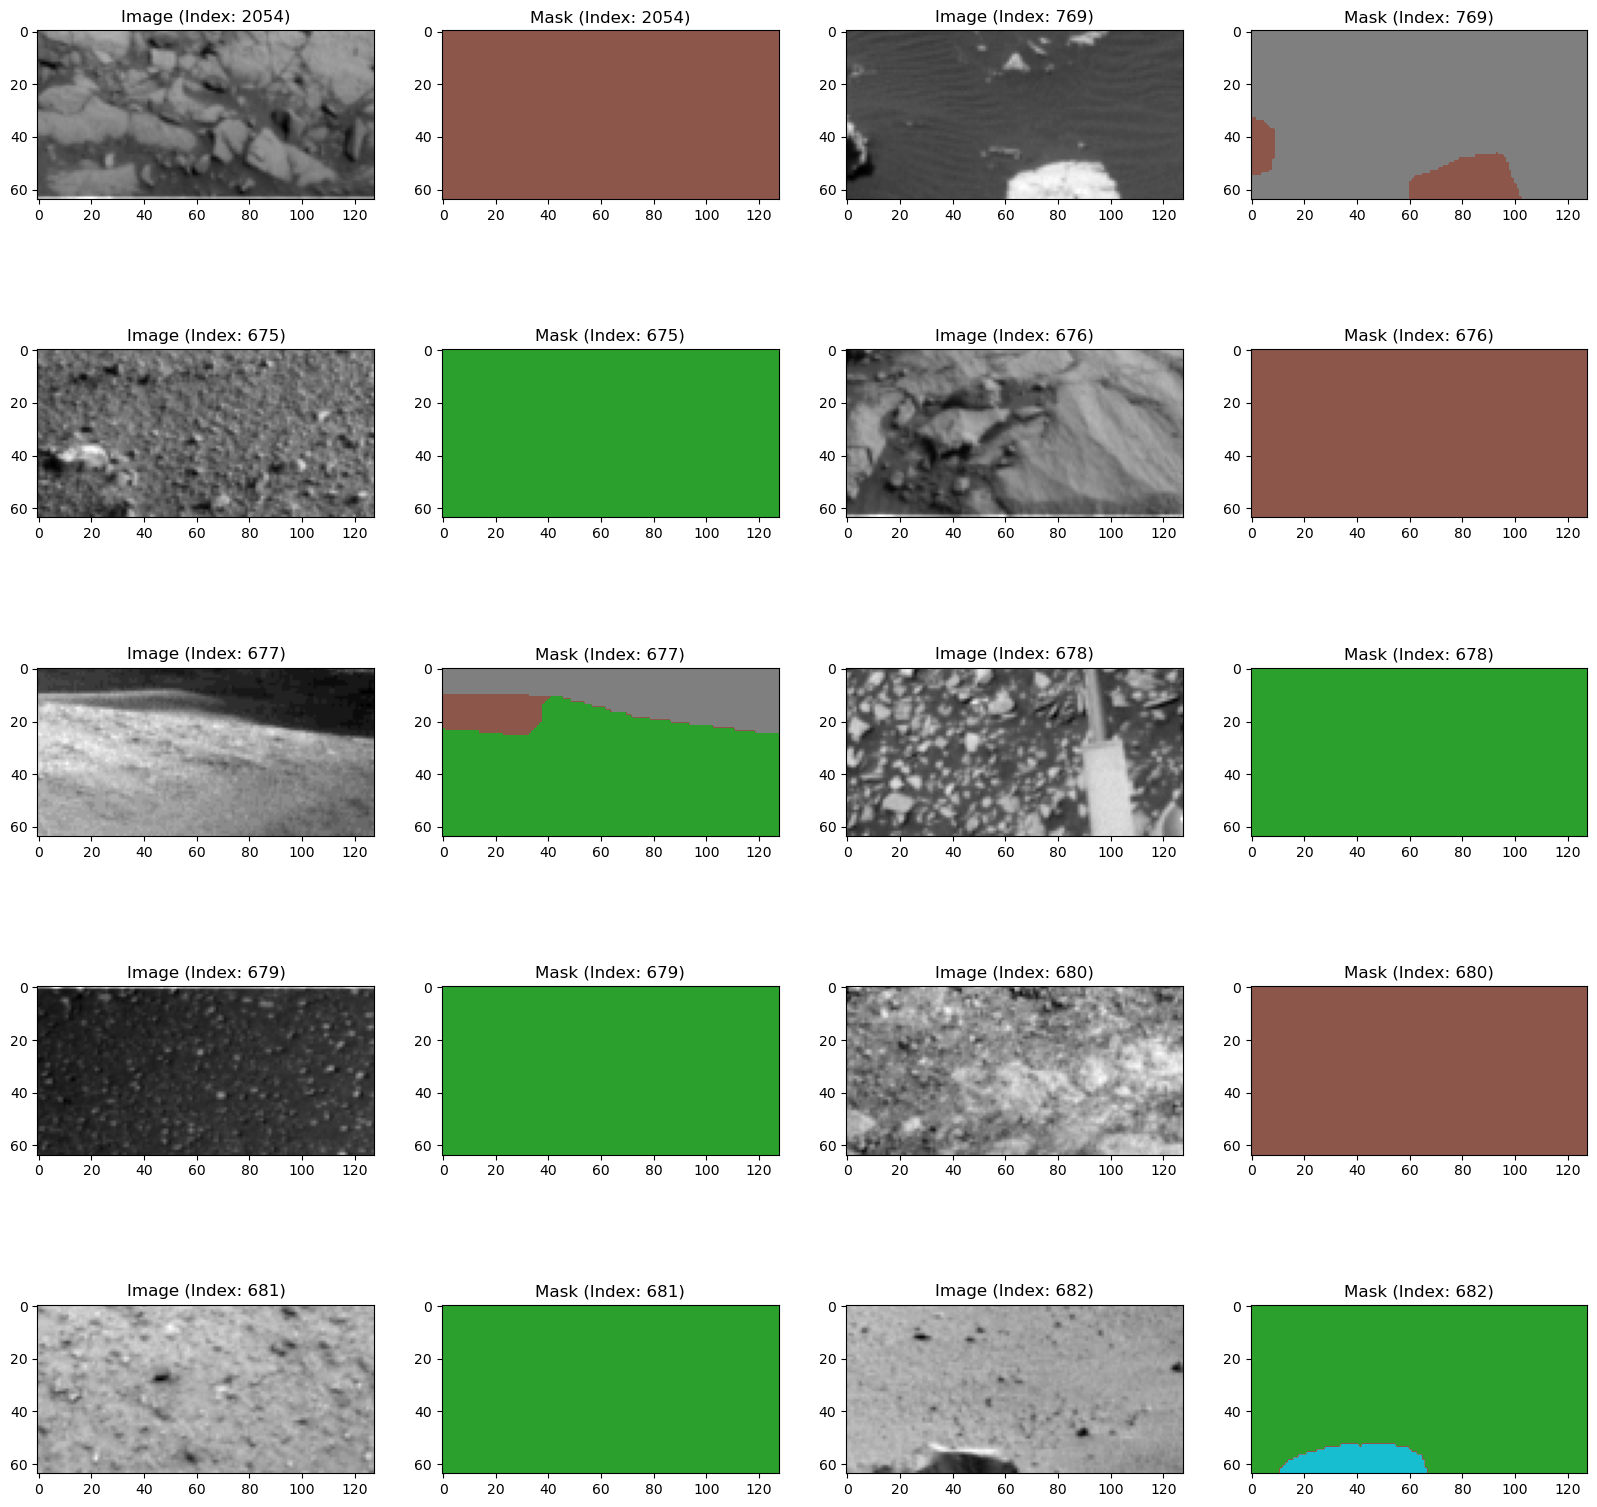

In [16]:
# Find the index of the mask with the most class 0
class_0_counts = np.sum(y_train == 0, axis=(1, 2))
index_with_most_class_0 = np.argmax(class_0_counts)

# Find the top 10 indices with the most class 0
top_10_indices = np.argsort(class_0_counts)[-10:][::-1]

cmap = plt.cm.get_cmap('tab10', 5)

# Display the corresponding images and masks from X_train and y_train
plt.figure(figsize=(20, 20))
for i, idx in enumerate(top_10_indices):
    plt.subplot(5, 4, 2*i + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f'Image (Index: {idx})')
    
    plt.subplot(5, 4, 2*i + 2)
    plt.imshow(y_train[idx], cmap=cmap, vmin=0, vmax=4)
    plt.title(f'Mask (Index: {idx})')

labels = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
handles = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(5)]
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 0.5))
plt.show()

In [17]:
# Calculate the total number of pixels in each mask
total_pixels = y_train.shape[1] * y_train.shape[2]

# Calculate the number of background pixels in each mask
background_pixels = np.sum(y_train == 0, axis=(1, 2))

# Calculate the percentage of background pixels in each mask
background_percentage = background_pixels / total_pixels

# Find the number of images with more than 90% background pixels
num_images_with_90_percent_background = np.sum(background_percentage > 0.9)

print(f"Number of images with more than 90% background pixels: {num_images_with_90_percent_background}")

Number of images with more than 90% background pixels: 0


In [18]:
# Count the number of images containing each class
class_presence = np.zeros((y_train.shape[0], 5))

for i in range(5):
    class_presence[:, i] = np.any(y_train == i, axis=(1, 2))

class_counts = np.sum(class_presence, axis=0)

for i, count in enumerate(class_counts):
    print(f"Number of images containing class {i} ({labels[i]}): {int(count)}")

Number of images containing class 0 (Background): 0
Number of images containing class 1 (Soil): 1047
Number of images containing class 2 (Bedrock): 982
Number of images containing class 3 (Sand): 718
Number of images containing class 4 (Big Rock): 57


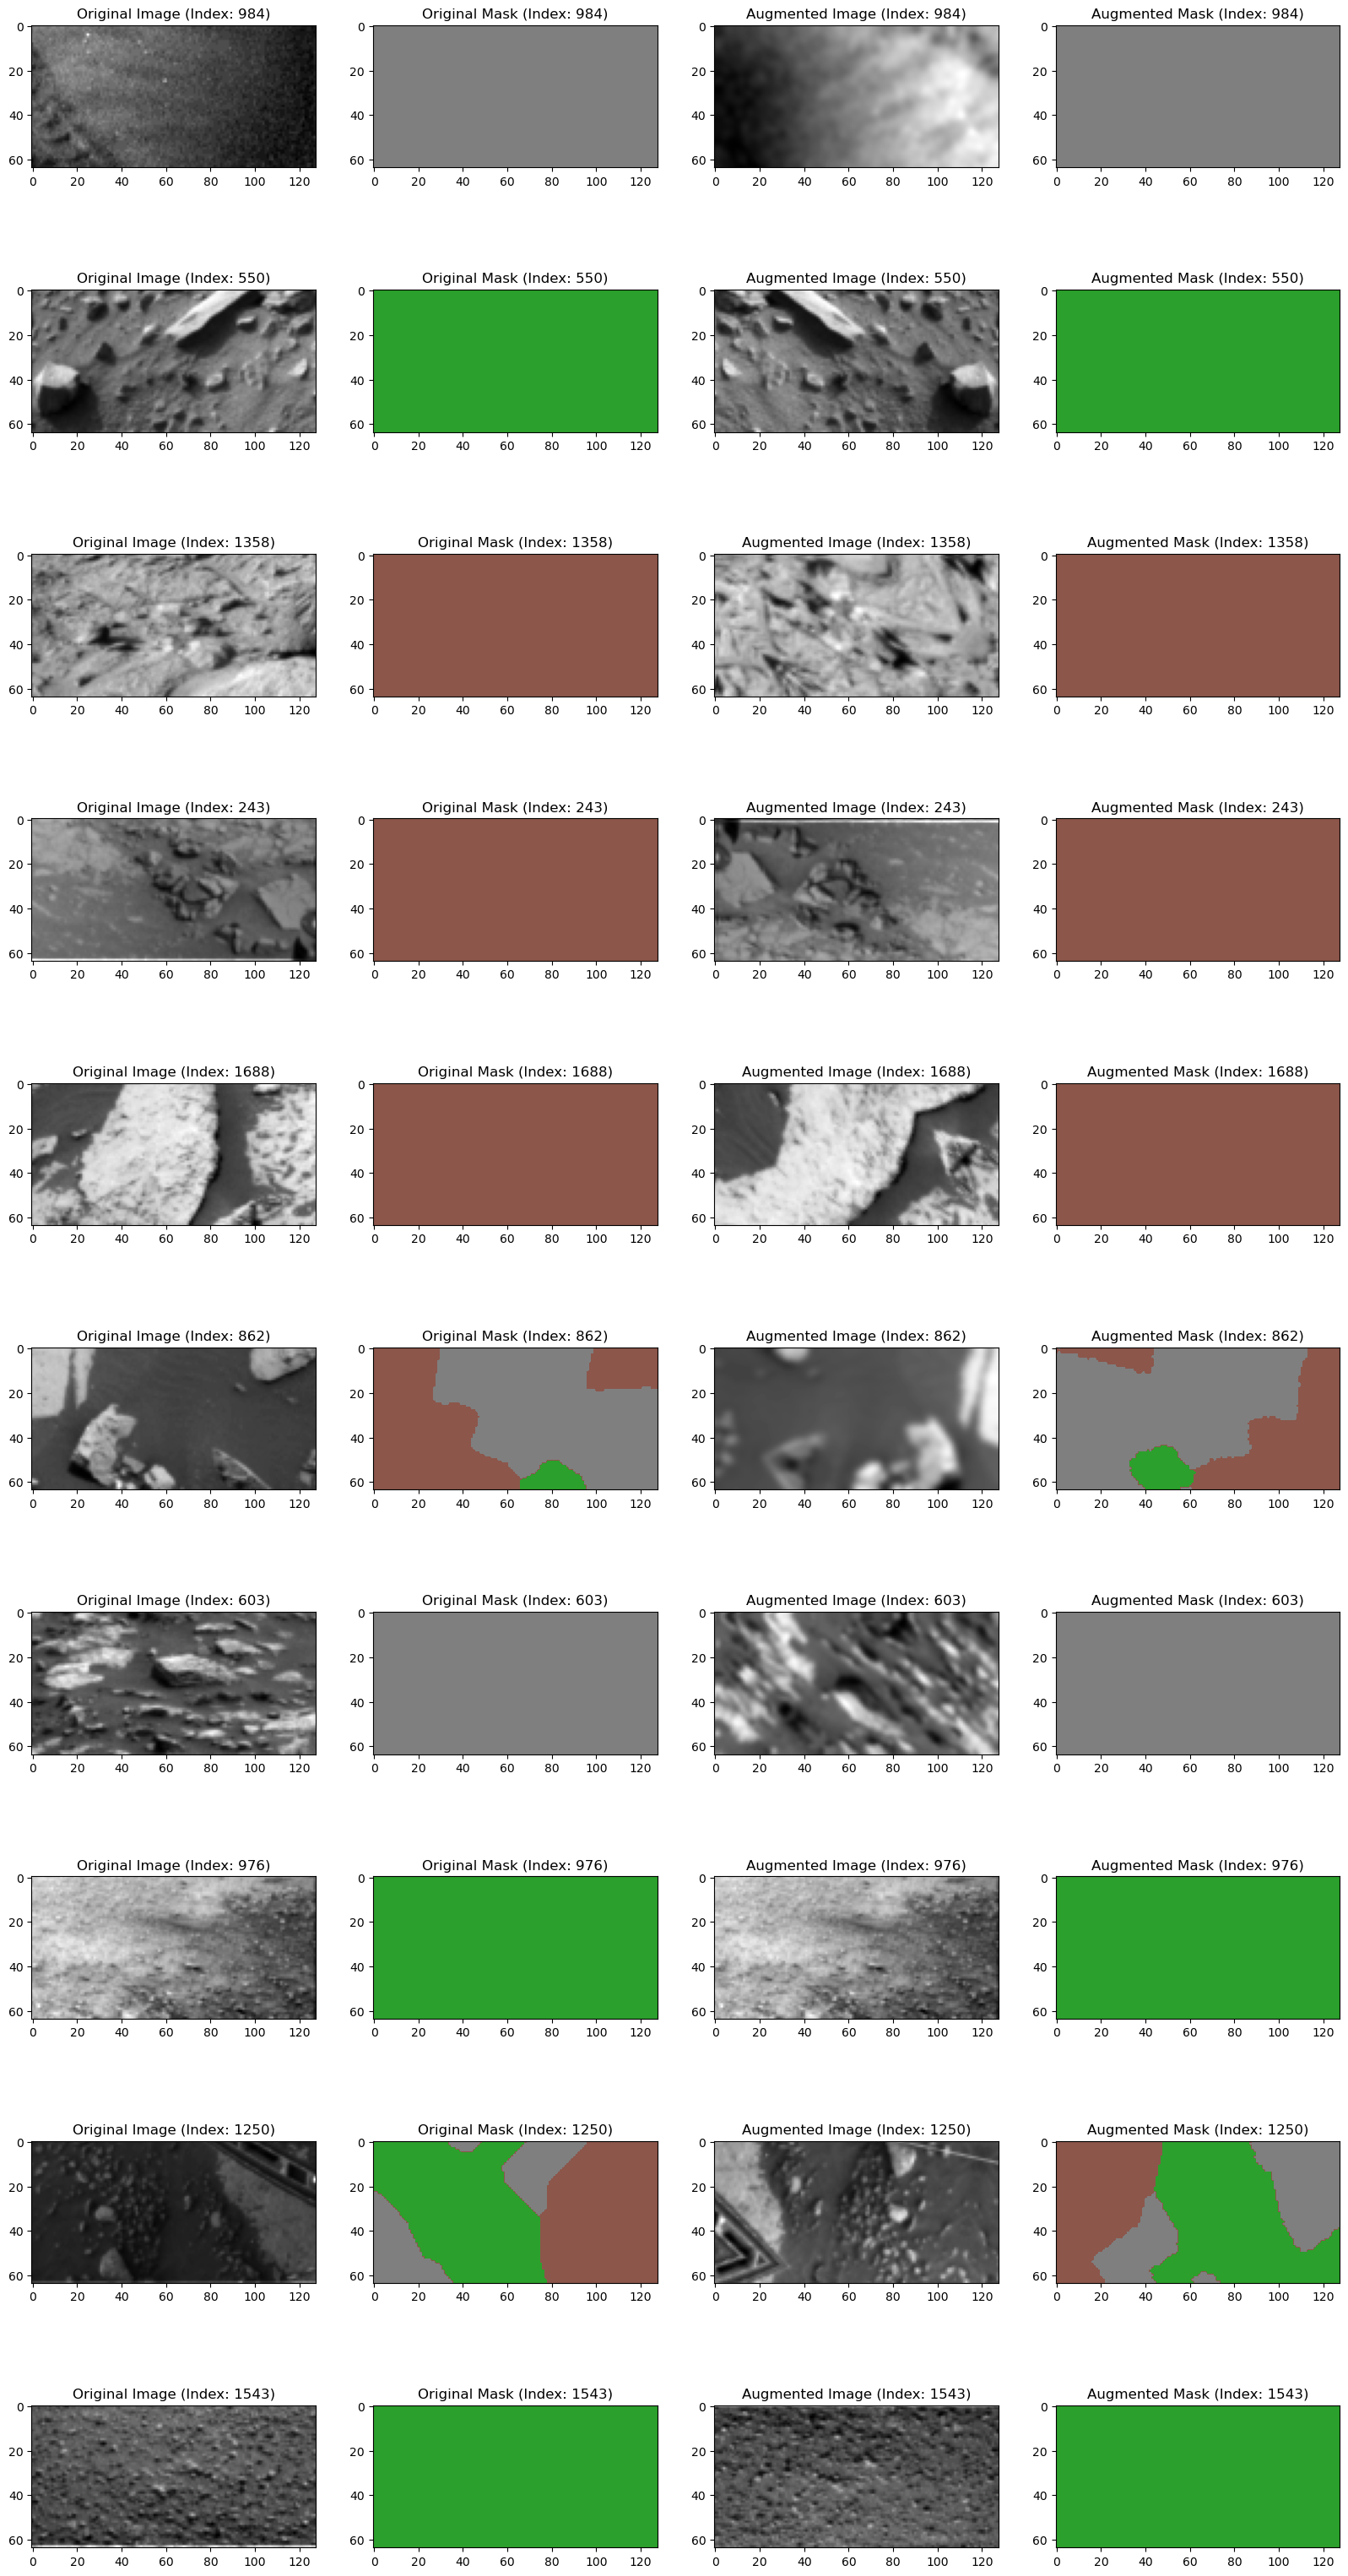

In [19]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.GaussianBlur(p=0.5),
    A.ElasticTransform(p=0.5)
])

# Function to apply augmentations
def augment_image(image, mask, num_augmentations=10):
    augmented_images = []
    augmented_masks = []
    for _ in range(num_augmentations):
        augmented = augmentation_pipeline(image=image, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])
    return np.array(augmented_images), np.array(augmented_masks)

# Pick 10 random indices
random_indices = np.random.choice(len(X_train), 10, replace=False)

# Display the original and augmented images and masks
plt.figure(figsize=(20, 40))
for i, idx in enumerate(random_indices):
    original_image = X_train[idx]
    original_mask = y_train[idx]
    augmented_images, augmented_masks = augment_image(original_image, original_mask, num_augmentations=1)
    
    plt.subplot(10, 4, 4*i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original Image (Index: {idx})')
    
    plt.subplot(10, 4, 4*i + 2)
    plt.imshow(original_mask, cmap=cmap, vmin=0, vmax=4)
    plt.title(f'Original Mask (Index: {idx})')
    
    plt.subplot(10, 4, 4*i + 3)
    plt.imshow(augmented_images[0], cmap='gray')
    plt.title(f'Augmented Image (Index: {idx})')
    
    plt.subplot(10, 4, 4*i + 4)
    plt.imshow(augmented_masks[0], cmap=cmap, vmin=0, vmax=4)
    plt.title(f'Augmented Mask (Index: {idx})')

plt.show()

[      0 8235183 6838728 5470086  960003]


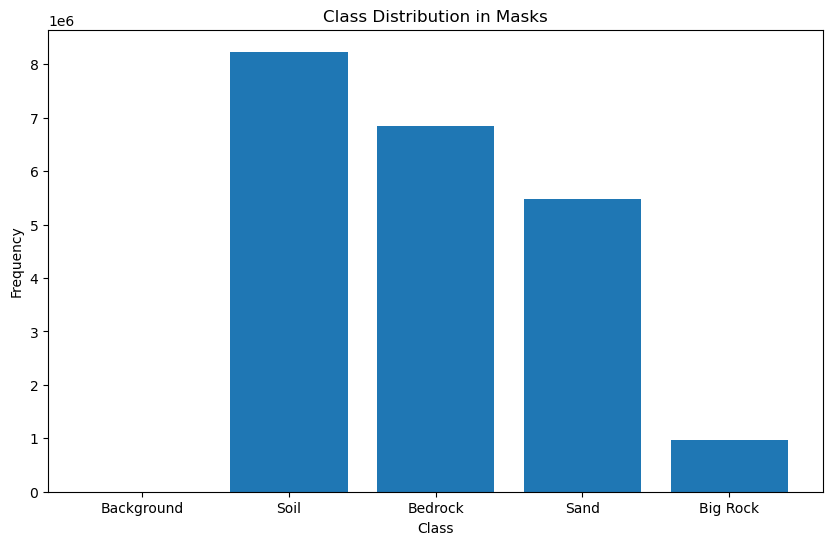

In [20]:
# Find indices of images containing class 4
class_4_indices = np.where(class_presence[:, 4] == 1)[0]

# Augment images containing class 4
augmented_X_train = []
augmented_y_train = []

for idx in class_4_indices:
    image = X_train[idx]
    mask = y_train[idx]
    aug_images, aug_masks = augment_image(image, mask)
    augmented_X_train.append(aug_images)
    augmented_y_train.append(aug_masks)

# Convert lists to numpy arrays and reshape
augmented_X_train = np.concatenate(augmented_X_train, axis=0)
augmented_y_train = np.concatenate(augmented_y_train, axis=0)

# Combine original and augmented data
X_train_balanced = np.concatenate((X_train, augmented_X_train), axis=0)
y_train_balanced = np.concatenate((y_train, augmented_y_train), axis=0)

# Verify the new class distribution
plot_class_distribution(y_train_balanced)

In [21]:
save_path = '../../data/new_beggining/balancish_no_background_interpolated_trainning_clean_mars.npz'
np.savez_compressed(save_path, X_train=X_train_balanced, y_train=y_train_balanced, X_test=X_test)